# WEAKLY SUPERVISED LOCALIZATION 
## USING CLASS ACTIVATION MAP 

In [1]:
import os
import numpy as np
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
import tensorflow as tf
import time
%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"]="1"
from tensorflow.python.client import device_lib
print device_lib.list_local_devices()

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
bus_adjacency: BUS_ANY
incarnation: 11662940895787831935
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11842874983
incarnation: 8036018548661234632
physical_device_desc: "device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:04:00.0"
]


In [2]:
# import urllib
# urllib.urlretrieve ("http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat",
#                     'imagenet-vgg-verydeep-19.mat')

# DEFINE FUNCTIONS

In [3]:
def imread(path):
    img = scipy.misc.imread(path).astype(np.float)
    if len(img.shape) == 2:
        img = np.transpose(np.array([img, img, img]), (2, 0, 1))
    return img
def imsave(path, img):
    img = np.clip(img, 0, 255).astype(np.uint8)
    scipy.misc.imsave(path, img)
def print_np(x, s):
    print ("Type of '%s' is %s" % (s, type(x)))
    print ("Shape of '%s' is %s" % (s, x.shape,))
    print ("dtype of '%s' is %s" % (s, x.dtype))

# LOAD DATA

In [4]:
cwd = os.getcwd()
# path = cwd + "/../cam/data/101_ObjectCategories"
path = cwd + "/data/sample2600"
valid_exts = [".jpg", ".gif", ".png", ".jpeg"]
print ("[%d] CATEGORIES ARE IN \n %s" % (len(os.listdir(path)), path))

categories = sorted(os.listdir(path))
ncategories = len(categories)

# Load from raw_data or npz file
is_load = 1
npzfile = 'data/sample2006.npz'
if is_load == 0:
    nimgs = 0
    for c in categories:
        nimgs += len([x for x in os.listdir(os.path.join(path,c)) if os.path.splitext(x)[1] in valid_exts])

    imgs = np.zeros((nimgs, 224, 224, 3), dtype=np.uint8)
    labels = np.zeros((nimgs, ncategories), dtype=np.bool)
    
    # LOAD ALL IMAGES 
    idx = 0
    t0 = time.time()
    for i, category in enumerate(categories):
        idx_prev = idx
        for f in os.listdir(path + "/" + category):
            ext = os.path.splitext(f)[1]
            if ext.lower() not in valid_exts:
                continue
            fullpath = os.path.join(path + "/" + category, f)
            img = scipy.misc.imresize(imread(fullpath), [224, 224, 3])
            imgs[idx, :, :, :] = img
            labels[idx, i] = 1
            idx += 1
            if idx % 20 == 0:
                print ("[%d/%d] imgs are loaded" % (idx, nimgs))
        print ("%d/%d %d %s imgs are loaded" % (i+1, ncategories, idx-idx_prev, category))
    print ("Loading ends in %d sec" % (time.time()-t0))
    np.savez(npzfile, imgs=imgs, labels=labels, nimgs=nimgs)
else:
    data = np.load(npzfile)
    imgs = data['imgs']
    labels = data['labels']
    nimgs = data['nimgs']
    
print ("Num imgs: %d" % (imgs.shape[0]))
print ("Num labels: %d" % (labels.shape[0]) )

[4] CATEGORIES ARE IN 
 /home/chang/notebooks/cam_vgg/data/sample2600
Num imgs: 2600
Num labels: 2600


# DIVIDE THE DATASET INTO TWO

In [5]:
ndata = len(imgs)
ntrain = int(ndata*0.7) # WILL USE 70% FOR TRAINING
ntest = ndata-ntrain
randidx = np.random.permutation(ndata)
trainidx = randidx[:ntrain]
testidx = randidx[ntrain+1:]
train_imgs = imgs[trainidx, ...]
train_labels = labels[trainidx, ...]
test_imgs = imgs[testidx, ...]
test_labels = labels[testidx, ...]

# PLOT DATASET

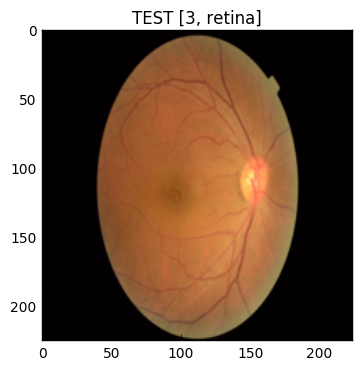

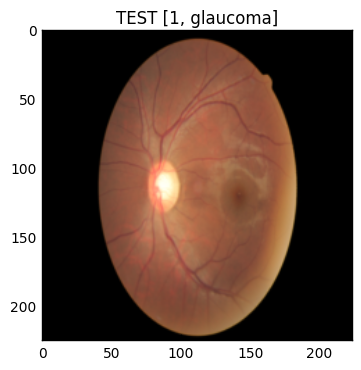

In [6]:
randidx = np.sort(np.random.randint(ntrain, size=2))
for i, j in enumerate(randidx):
    curr_img = train_imgs[j, :, :, :]
    curr_label = np.argmax(train_labels[j, :])
    plt.figure(i)
    plt.imshow(curr_img)
    plt.title("TRAIN [" + str(curr_label) + ", " + categories[curr_label] + "]")
    plt.draw()
randidx = np.sort(np.random.randint(ntest, size=2))
for i, j in enumerate(randidx):
    curr_img = test_imgs[j, :, :, :]
    curr_label = np.argmax(test_labels[j, :])
    plt.figure(i)
    plt.imshow(curr_img)
    plt.title("TEST [" + str(curr_label) + ", " + categories[curr_label] + "]")
    plt.draw()

# HELPER FUNCTIONS FOR LOADING PRETRAINED NETWORK

In [7]:
def loadnet(data_path, _layers, trainable=False):
    data = scipy.io.loadmat(data_path) # Read .mat file via scipy.io.loadmat
    # mean = data['normalization'][0][0][0]
    mean = data['meta'][0][0][2][0][0][2]
    mean_pixel = np.mean(mean, axis=(0, 1))
    parameters = data['layers'][0]
    weights = {}
    biases = {}
    for i, name in enumerate(_layers):
        kind = name[:4]
        if kind == 'conv':
            kernels, bias = parameters[i][0][0][2][0]
            # kernels, bias = weights[i][0][0][0][0]
            # matconvnet: weights are [width, height, in_channels, out_channels]
            # tensorflow: weights are [height, width, in_channels, out_channels]
            kernels = np.transpose(kernels, (1, 0 , 2, 3))
            bias = bias.reshape(-1)
            weights[name] = tf.Variable(kernels, name=name, trainable=trainable)
            biases[name] = tf.Variable(bias, name=name, trainable=trainable)
    return weights, biases, mean_pixel

def feednet(_W, _b, _layers, _mean_pixel, _input_image):
    featmap = _input_image - _mean_pixel
    for i, name in enumerate(_layers):
        kind = name[:4]
        if kind == 'conv':
            with tf.name_scope(name):
                featmap = tf.nn.conv2d(featmap, _W[name], strides=[1, 1, 1, 1], padding='SAME')
                featmap = tf.nn.bias_add(featmap, _b[name])
        elif kind == 'relu':
            featmap = tf.nn.relu(featmap, name=name)
        elif kind == 'pool':
            featmap = tf.nn.max_pool(featmap, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                                     padding='SAME', name=name)
    return featmap

print ("Functions for LOAD PRETRAINED MODEL ready")

Functions for LOAD PRETRAINED MODEL ready


# LOAD PRETRAINED VGG19

In [8]:
cwd = os.getcwd()
VGG_PATH = cwd + "/imagenet-vgg-verydeep-19.mat"
layers = (
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',
        'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',
        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
        'relu3_3', 'conv3_4', 'relu3_4', 'pool3',
        'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
        'relu4_3', 'conv4_4', 'relu4_4', 'pool4',
        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
        'relu5_3', 'conv5_4', 'relu5_4'
    )

# You can choose trainable=True / False
# If trainable=True, you can finetune pretrained network as well as cam layer
_weights, _biases, _ = loadnet(VGG_PATH, layers, trainable=False)
weights, biases, mean_pixel = loadnet(VGG_PATH, layers, trainable=True)
print ("Network for VGG ready")

Network for VGG ready


# DEFINE GAP NETWORK

In [9]:
# PARAMETERS
n_output = ncategories
img_placeholder = tf.placeholder('float', shape=(None, 224, 224, 3))
y = tf.placeholder('float', [None, n_output])
kr = tf.placeholder('float')
weights['conv_gap'] = tf.Variable(tf.truncated_normal([3, 3, 512, 512], stddev=0.1))
weights['out'] = tf.Variable(tf.random_normal([512, n_output], stddev=0.1))
biases['conv_gap'] = tf.Variable(tf.random_normal([512], stddev=0.01))
biases['out'] = tf.Variable(tf.random_normal([n_output], stddev=0.01))
# NETWORK
def cam(_x, _W, _b, _kr):
    cam_conv = tf.nn.conv2d(_x, _W['conv_gap'], strides=[1, 1, 1, 1], padding='SAME')
    cam_relu = tf.nn.relu(tf.nn.bias_add(cam_conv, _b['conv_gap']))
    gap = tf.nn.avg_pool(cam_relu, ksize=[1, 14, 14, 1], strides=[1, 14, 14, 1],
            padding='SAME')
    gap_dr = tf.nn.dropout(gap, _kr)
    gap_vec = tf.reshape(gap_dr, [-1, _W['out'].get_shape().as_list()[0]])
    out = tf.add(tf.matmul(gap_vec, _W['out']), _b['out'])
    ret = {'cam_conv': cam_conv, 'cam_relu': cam_relu,
           'gap': gap, 'gap_dr': gap_dr, 'gap_vec': gap_vec, 'out': out}
    return ret
print ("NETWORK READY")

NETWORK READY


# DEFINE FUNCTIONS FOR THE NETWORK

In [10]:
# For initializing cam weights w/o backprop through vgg19
_fnet = feednet(_weights, _biases, layers, mean_pixel, img_placeholder)
_fcam = cam(_fnet, weights, biases, kr)['cam_relu']
_pred = cam(_fnet, weights, biases, kr)['out']
_cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(_pred, y))
_optm = tf.train.AdamOptimizer(learning_rate=0.001).minimize(_cost)

# For fintuning vgg19
fnet = feednet(weights, biases, layers, mean_pixel, img_placeholder)
fcam = cam(fnet, weights, biases, kr)['cam_relu']
pred = cam(fnet, weights, biases, kr)['out']
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optm = tf.train.AdamOptimizer(learning_rate=0.00003).minimize(cost)
corr = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accr = tf.reduce_mean(tf.cast(corr, 'float'))
init = tf.initialize_all_variables()
print ("FUNCTIONS READY")

FUNCTIONS READY


# TRAIN THE NETWRORK

In [11]:
import time

# SOME PARAMETERS
training_epochs = 40
batch_size = 128
total_batch = (ntrain // batch_size) + 1
disp_step = 1

t0 = time.time()

sess = tf.InteractiveSession()
sess.run(init)

for epoch in xrange(training_epochs):
    avg_cost = 0.
    randperm = np.random.permutation(ntrain)
    
    for i in range(total_batch):
        randidx = randperm[i*batch_size:(i+1)*batch_size]
        batch_x = train_imgs[randidx, :, :, :]
        batch_y = train_labels[randidx, :]
        feeds_iter = {img_placeholder: batch_x, y: batch_y, kr: 0.7}
        if epoch < 10:
            _, c = sess.run([_optm, _cost], feed_dict=feeds_iter)
        else:
            _, c = sess.run([optm, cost], feed_dict=feeds_iter)
        avg_cost += c 
        # print (c)
    avg_cost = avg_cost / total_batch
    if epoch % disp_step == 0:
        feeds_train = {img_placeholder: batch_x, y: batch_y, kr: 1.}
        train_acc = sess.run(accr, feed_dict=feeds_train)
        test_idx = np.random.randint(len(test_imgs), size=100)
        test_imgs_temp = test_imgs[test_idx, :, :, :]
        test_labels_temp = test_labels[test_idx, :]
        feeds_test = {img_placeholder: test_imgs_temp, y: test_labels_temp, kr: 1.}
        test_acc = sess.run(accr, feed_dict=feeds_test)
        print ("[%d/%d] cost: %.4f train_acc: %.3f test_acc: %.3f" 
               % (epoch+1, training_epochs, avg_cost, train_acc, test_acc))
print ("OPTIMIZATION FINISHED in %d sec" % (time.time() - t0))

[1/40] cost: 18.0922 train_acc: 0.370 test_acc: 0.490
[2/40] cost: 9.3129 train_acc: 0.630 test_acc: 0.490
[3/40] cost: 6.7683 train_acc: 0.667 test_acc: 0.580
[4/40] cost: 4.7331 train_acc: 0.667 test_acc: 0.650
[5/40] cost: 3.2429 train_acc: 0.778 test_acc: 0.610
[6/40] cost: 2.5733 train_acc: 0.778 test_acc: 0.500
[7/40] cost: 2.1083 train_acc: 0.593 test_acc: 0.560
[8/40] cost: 1.8546 train_acc: 0.593 test_acc: 0.580
[9/40] cost: 1.6594 train_acc: 0.852 test_acc: 0.620
[10/40] cost: 1.3786 train_acc: 0.704 test_acc: 0.540
[11/40] cost: 1.9164 train_acc: 0.704 test_acc: 0.520
[12/40] cost: 1.0253 train_acc: 0.630 test_acc: 0.610
[13/40] cost: 0.8323 train_acc: 0.815 test_acc: 0.600
[14/40] cost: 0.6486 train_acc: 1.000 test_acc: 0.630
[15/40] cost: 0.6105 train_acc: 0.852 test_acc: 0.640
[16/40] cost: 0.4494 train_acc: 1.000 test_acc: 0.620
[17/40] cost: 0.3686 train_acc: 0.889 test_acc: 0.680
[18/40] cost: 0.2980 train_acc: 1.000 test_acc: 0.650
[19/40] cost: 0.2092 train_acc: 1.00

GT : retina
top1 (0.945): retina
top2 (0.055): normal


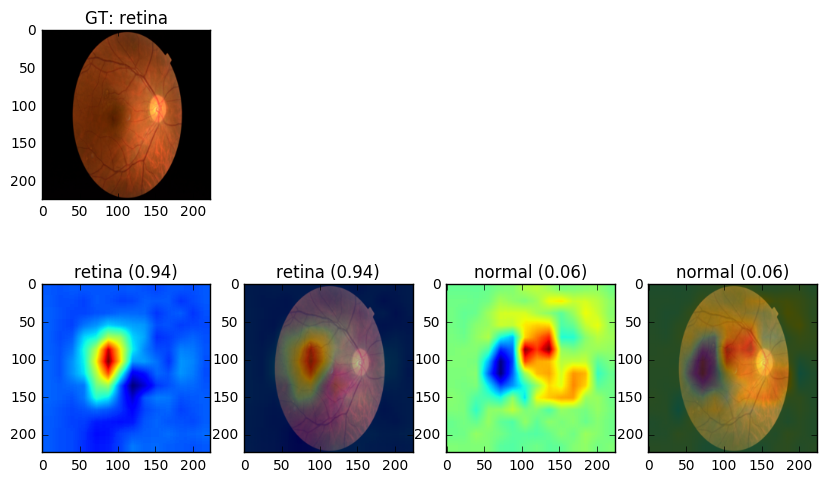

GT : retina
top1 (1.000): retina
top2 (0.000): cataract


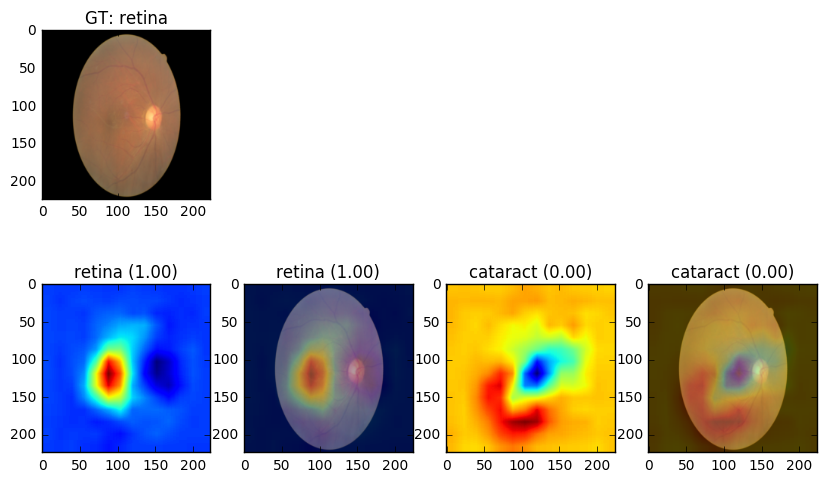

GT : normal
top1 (0.652): normal
top2 (0.326): glaucoma


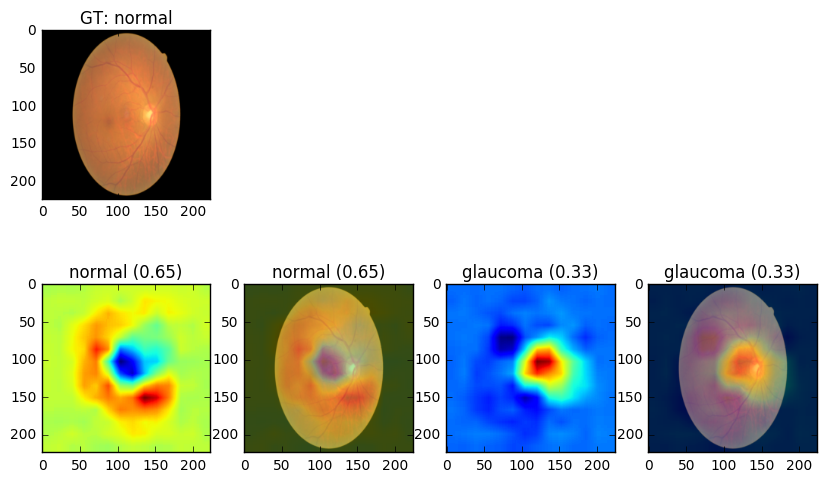

GT : normal
top1 (1.000): cataract
top2 (0.000): normal


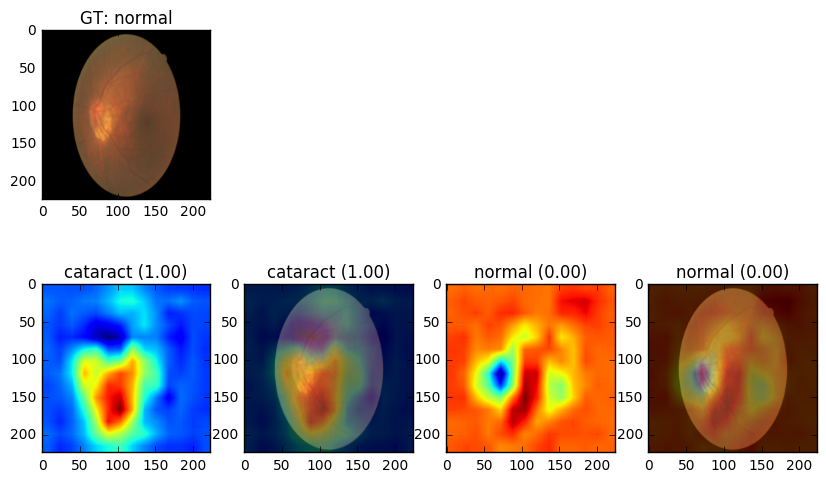

GT : normal
top1 (1.000): normal
top2 (0.000): retina


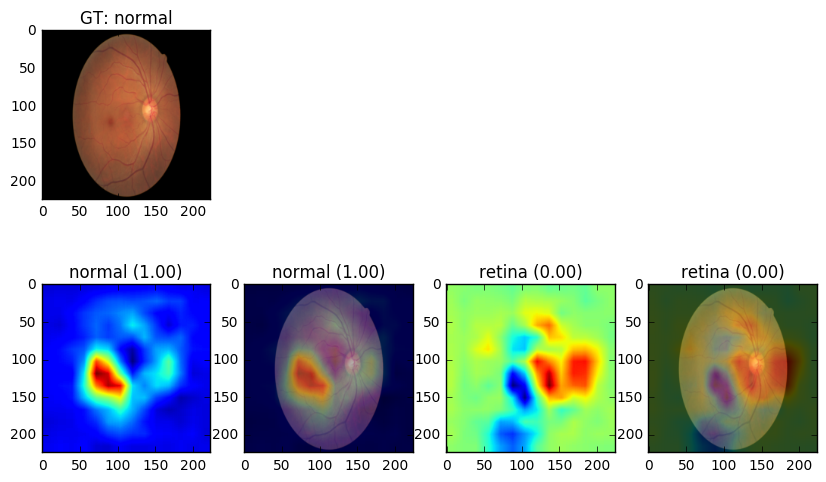

GT : retina
top1 (0.999): retina
top2 (0.001): cataract


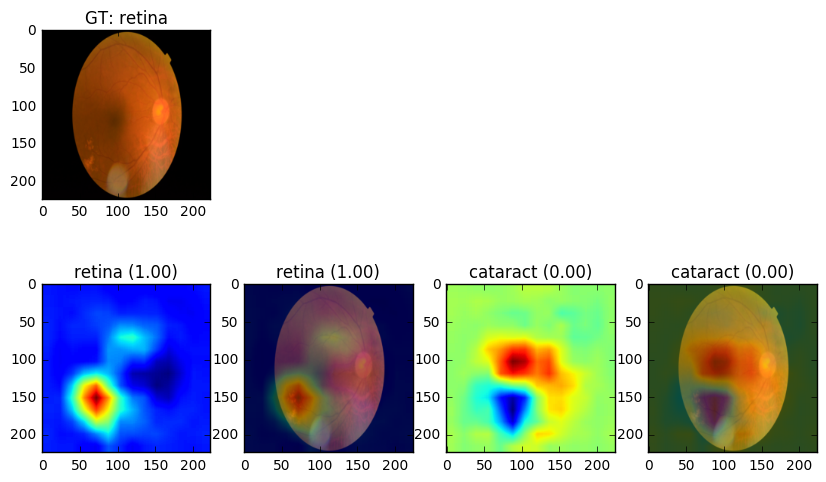

GT : retina
top1 (0.919): retina
top2 (0.081): normal


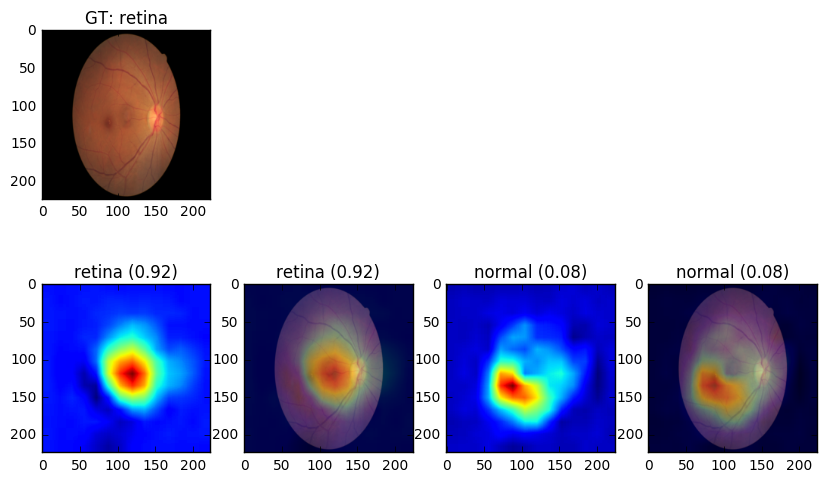

GT : normal
top1 (0.793): retina
top2 (0.203): normal


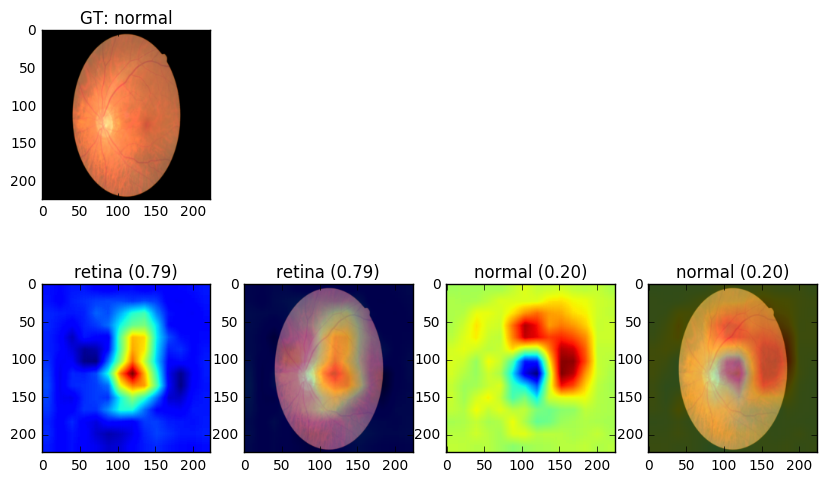

GT : normal
top1 (0.929): normal
top2 (0.057): retina


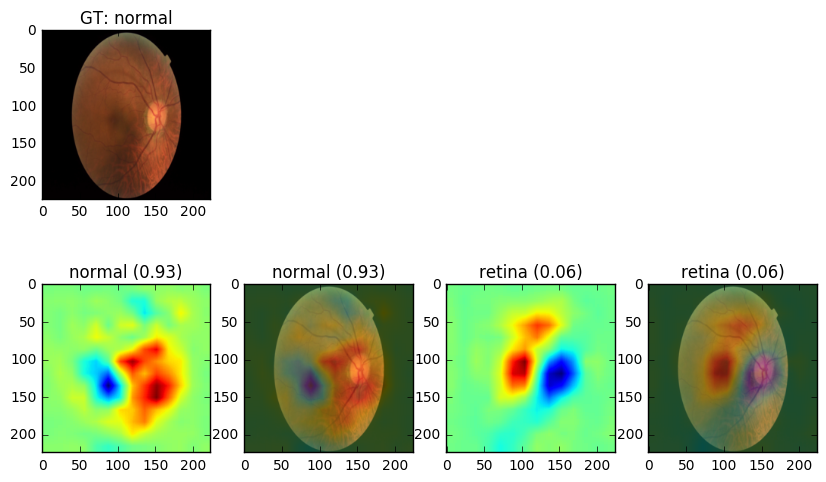

GT : glaucoma
top1 (0.799): normal
top2 (0.201): glaucoma


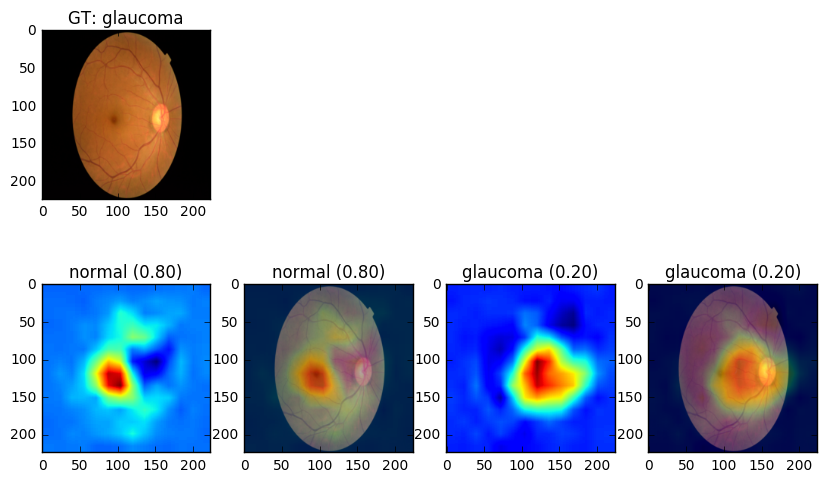

GT : retina
top1 (0.996): retina
top2 (0.004): glaucoma


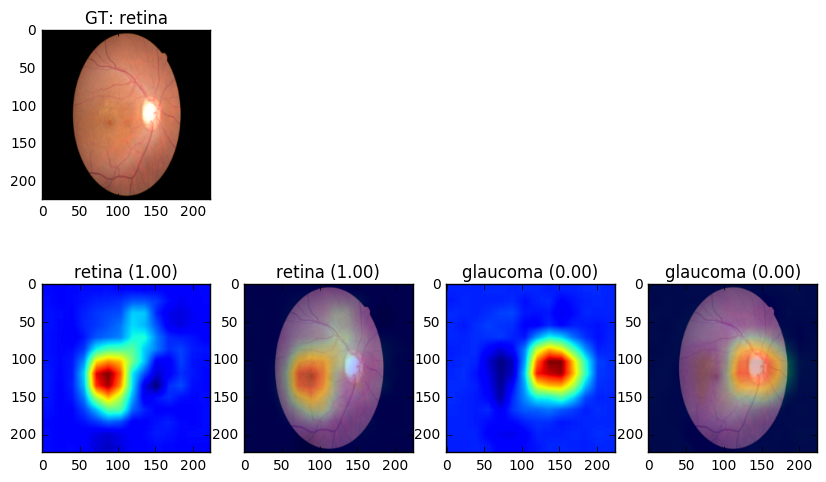

GT : normal
top1 (1.000): glaucoma
top2 (0.000): retina


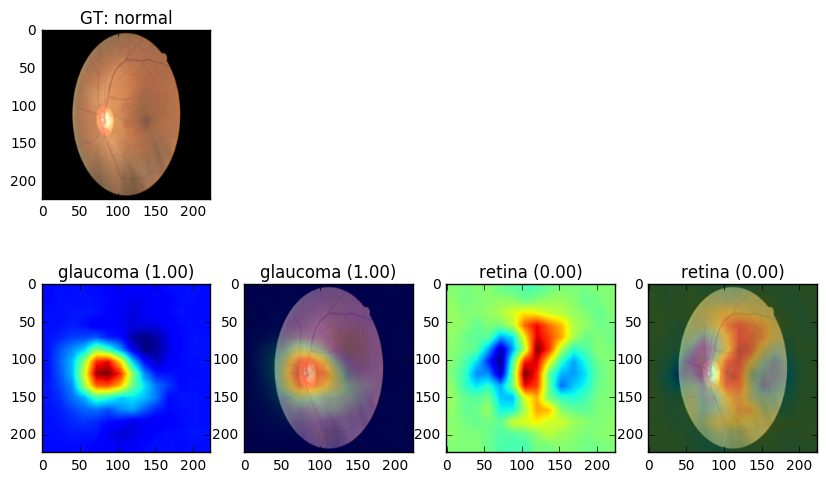

GT : retina
top1 (1.000): retina
top2 (0.000): normal


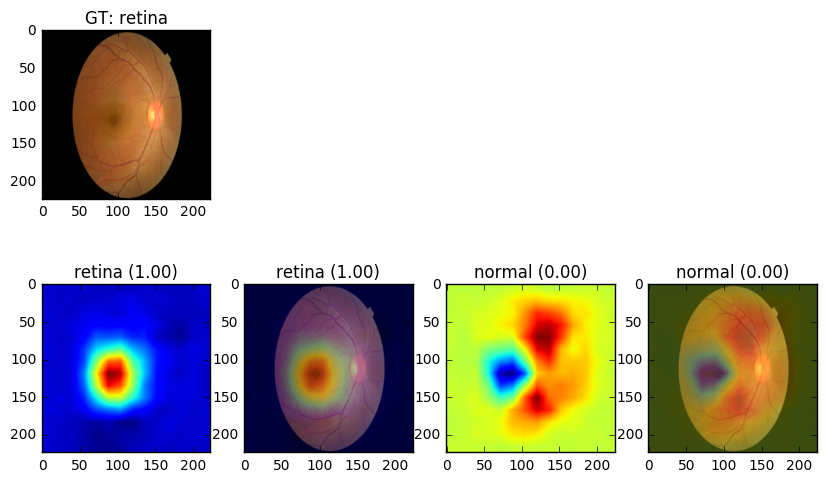

GT : retina
top1 (0.942): normal
top2 (0.058): glaucoma


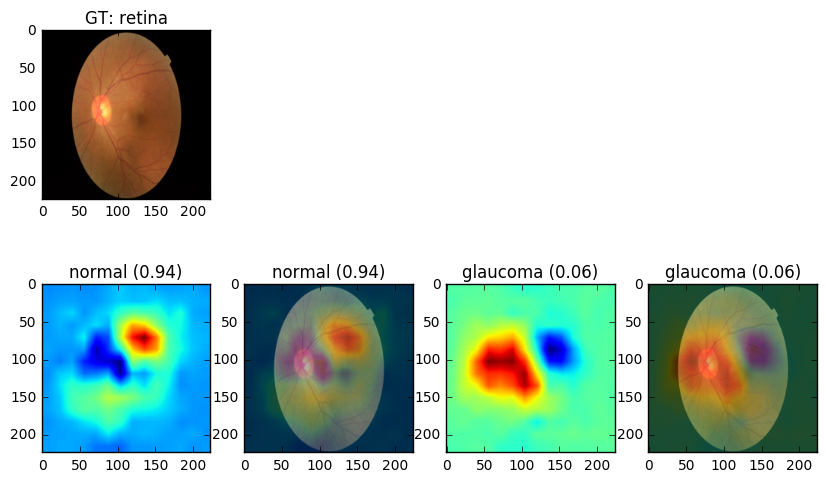

GT : retina
top1 (0.905): cataract
top2 (0.069): glaucoma


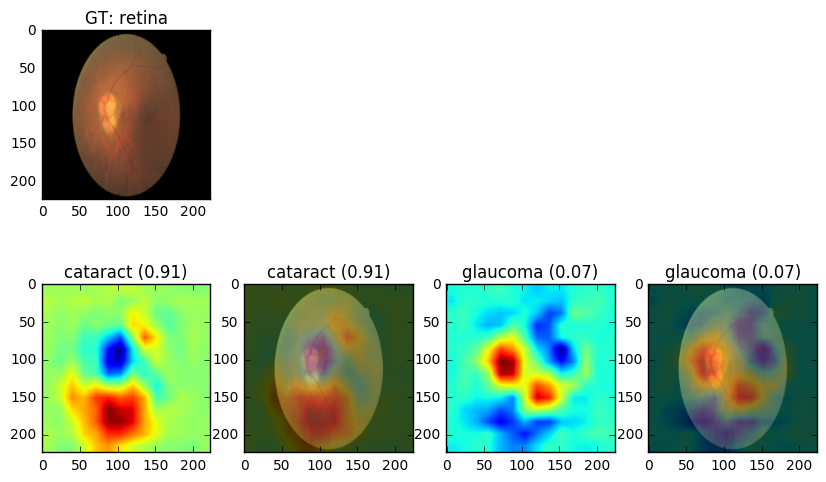

GT : retina
top1 (0.892): retina
top2 (0.089): normal


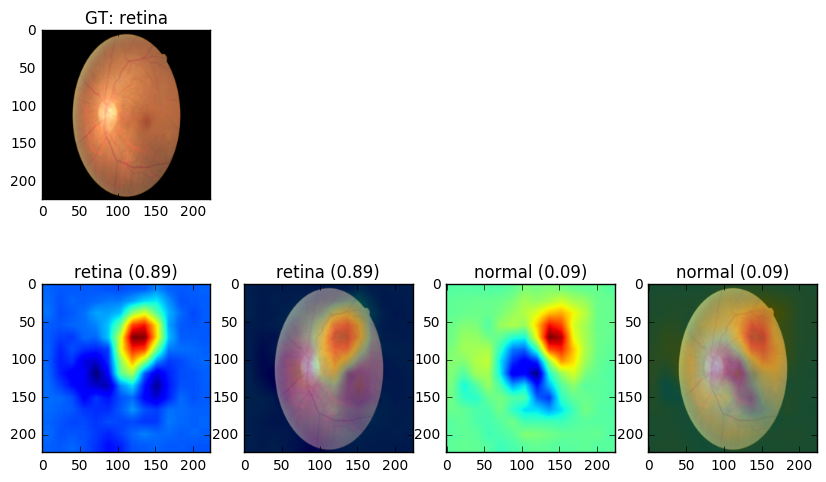

GT : glaucoma
top1 (0.983): glaucoma
top2 (0.017): normal


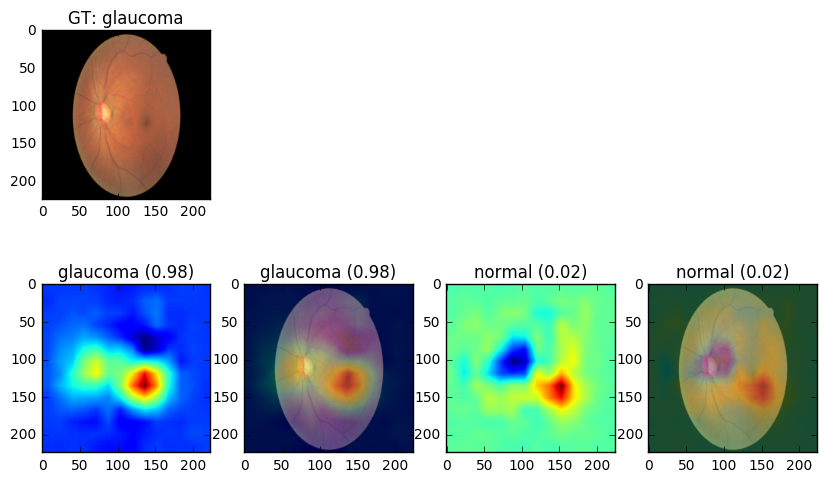

GT : retina
top1 (1.000): retina
top2 (0.000): normal


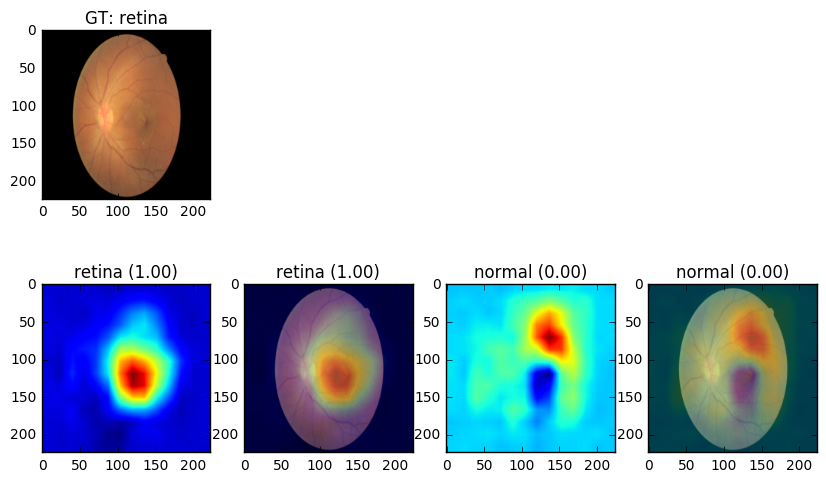

GT : cataract
top1 (0.994): retina
top2 (0.005): cataract


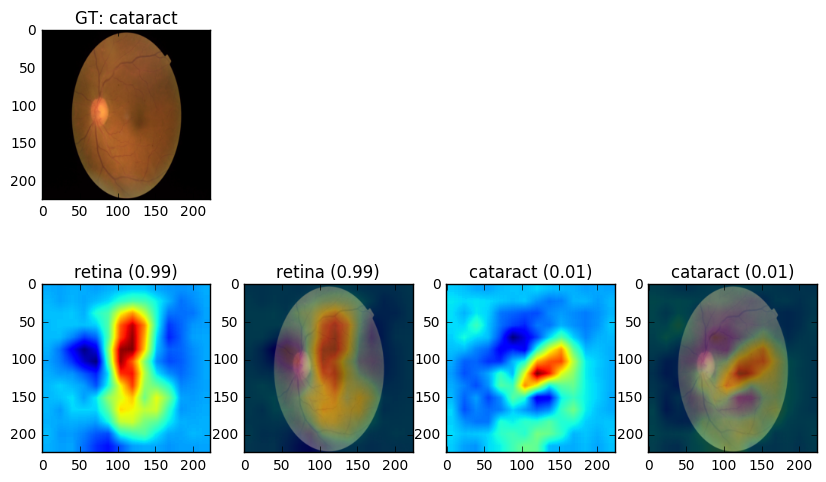

GT : normal
top1 (1.000): normal
top2 (0.000): retina


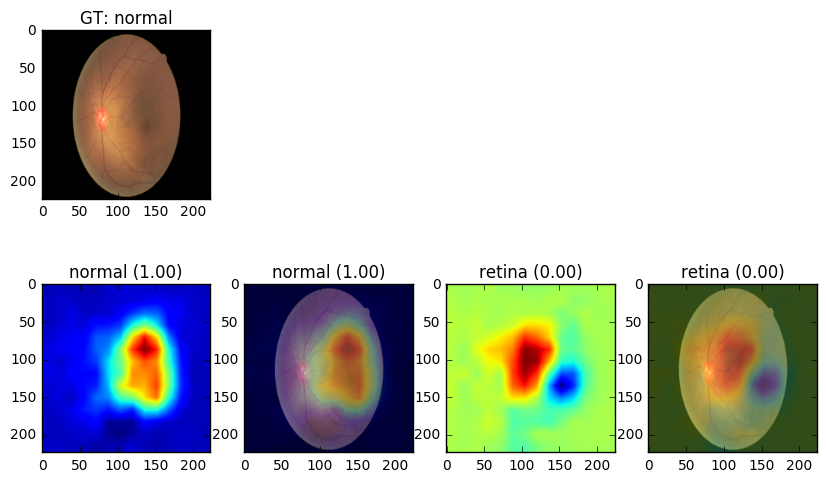

GT : retina
top1 (1.000): retina
top2 (0.000): normal


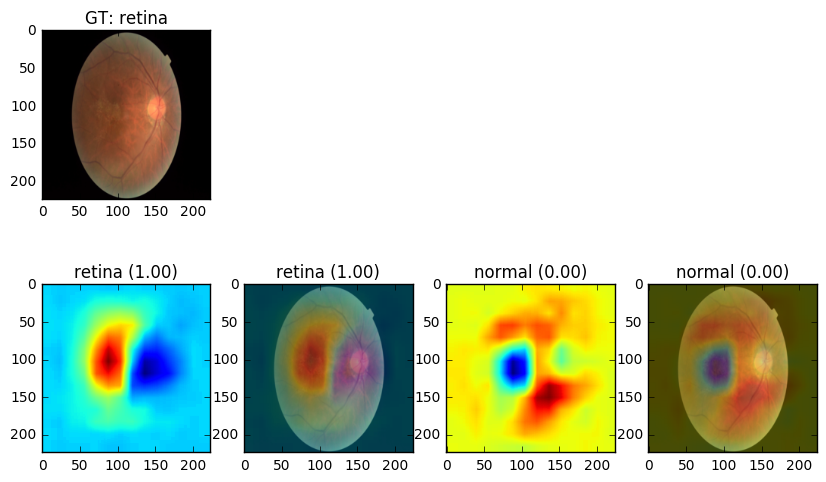

GT : normal
top1 (0.992): normal
top2 (0.004): retina


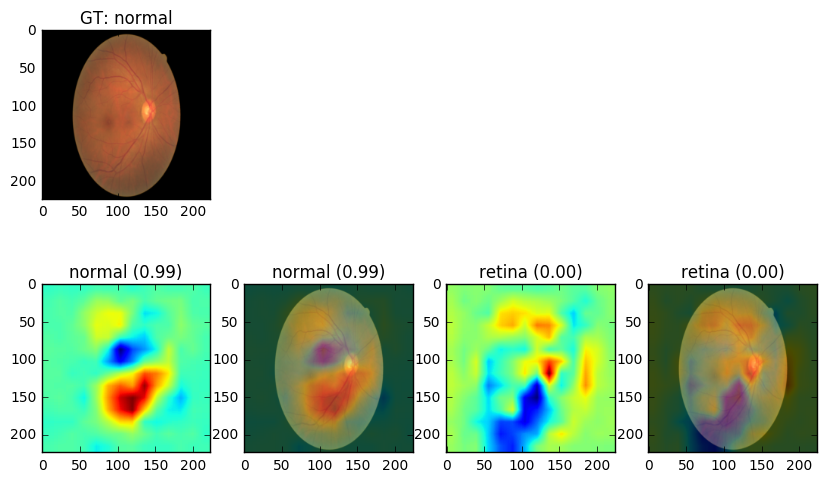

GT : normal
top1 (1.000): normal
top2 (0.000): retina


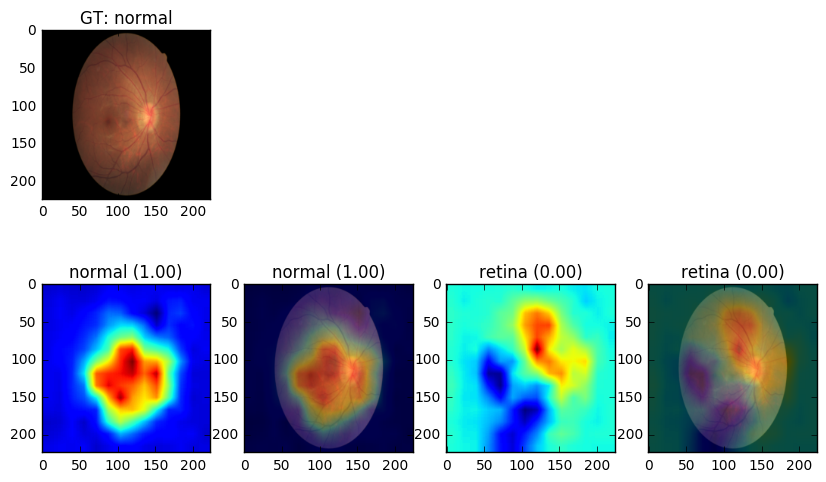

GT : retina
top1 (0.937): normal
top2 (0.063): retina


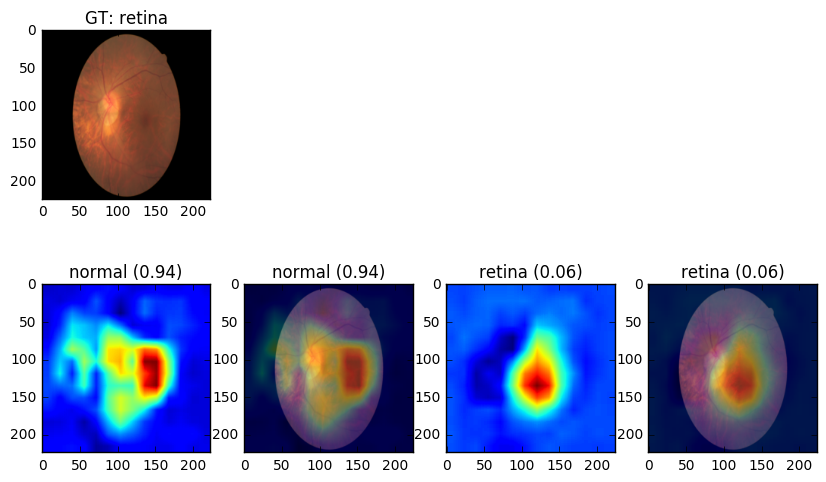

GT : glaucoma
top1 (1.000): glaucoma
top2 (0.000): normal


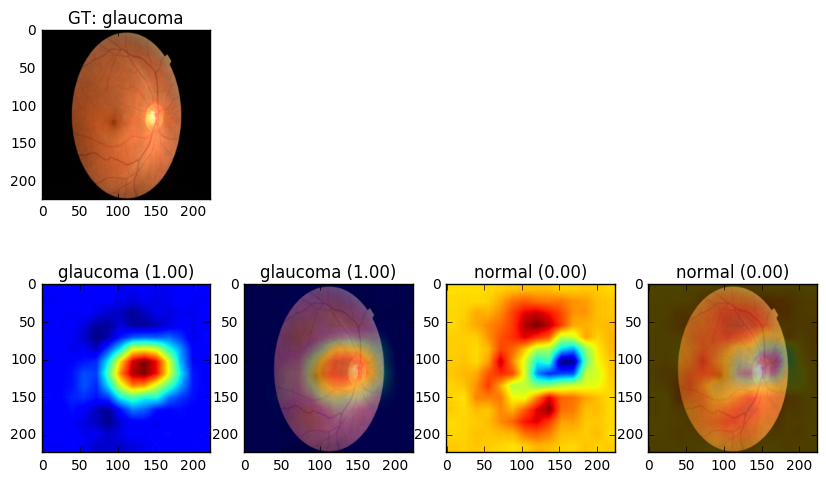

In [17]:
# Get Random Image
ntop = 2
nview = 25
ntest = test_imgs.shape[0]
randidx = np.random.randint(ntest, size=nview)
testimg = test_imgs[randidx, ...]
testlabel = test_labels[randidx, :]
predprob = tf.nn.softmax(pred)
for i in xrange(nview):
    currimg = testimg[i].reshape((-1,) + testimg[i].shape)
    currlabel = np.argmax(testlabel[i])
    cam_testfeat, cam_outval, cam_weights = sess.run([fcam, predprob, weights['out']],
                                                    feed_dict={img_placeholder: currimg, kr: 1.})
    
    predtop5 = np.argsort(-cam_outval[0])[:5]
    print "GT : %s" % (categories[currlabel])
    for j in xrange(ntop):
        print "top%1d (%.3f): %s" % (j+1, cam_outval[0, predtop5[j]], categories[predtop5[j]])
    
    plt.figure(i, figsize=(10,6))
    plt.subplot(2, 2*ntop,1)
    plt.imshow(currimg[0])
    plt.title("GT: {}".format(categories[currlabel]))
    
    for j in xrange(ntop):
        predlabel = predtop5[j]
        predweights = cam_weights[:, predlabel]
        camsum = np.zeros((14, 14))
        for i in xrange(512):
            camsum = camsum + predweights[i] * cam_testfeat[0,:,:,i]

        camavg = scipy.misc.imresize(camsum / 512, [224, 224])

        cm_jet = plt.get_cmap('jet')
        camadd = camavg.copy().astype(np.float) - np.min(camavg)
        camadd = camadd / np.max(camadd)
        camadd = 0.7*currimg[0]/255. + 0.3*cm_jet(camadd)[..., :3]

        plt.subplot(2, 2*ntop, 2*ntop+2*j+1)
        plt.imshow(camavg)
        # plt.matshow(camavg, cmap=plt.get_cmap('jet'))
        plt.title(categories[predlabel]+" ({:.2f})".format(cam_outval[0, predtop5[j]]))
        # plt.colorbar()
        
        plt.subplot(2, 2*ntop, 2*ntop+2*j+2)
        plt.imshow(camadd)
        plt.title(categories[predlabel]+" ({:.2f})".format(cam_outval[0, predtop5[j]]))
    plt.show()